# RasterIO for dummies: a brief intro to a *pythonic* raster library

In order to run this notebook, please do what follows:

    cd  /media/sf_LVM_shared/my_SE_data/exercise
    jupyter-notebook RasterIO_Intro.ipynb || jupyter lab RasterIO_Intro.ipynb 

---


**RasterIO** is a library that simplifies the use of the raster swiss-knife geospatial library (**GDAL**) from Python (... and talking about that, [how do you pronounce GDAL?](https://soundcloud.com/danabauer/how-do-you-pronounce-gdal)).

Ratio: GDAL is C++ library with a public C interface for other languages bindings, therefore its Python API is quite rough from the mean Python programmer's point of view (i.e. it is not *pythonic* enough). RasterIO is for rasters what Fiona is for vectors.

*Note: [`Open Source Approaches in Spatial Data Handling`](https://link.springer.com/book/10.1007/978-3-540-74831-1) is a good comprehensive book about the history and roles of FOSS in the geospatial domain.*


## 1.0 Reminder

You need to access the dataset we will use in this notebook and later too.
You already should have downloaded it and stored in the right folder, as follows:

    cd ~/SE_data
    git pull
    rsync -hvrPt --ignore-existing ~/SE_data/* /media/sf_LVM_shared/my_SE_data
    cd  /media/sf_LVM_shared/my_SE_data/exercise

    pip3 install gdown # Google Drive access

    [ -f tree_height.tar.gz ] || ~/.local/bin/gdown 1Y60EuLsfmTICTX-U_FxcE1odNAf04bd-
    [ -d tree_height ] || tar xvf tree_height.tar.gz
    
Also, you should already installed `rasterio` package as follows:
    
    pip3 install rasterio
    
*Hint: you should never use `pip3` under `sudo`, else you could break your system-wide Python environment in very creative and subtle ways.* 

## 1.1 Rasterio basics

In [1]:
import rasterio # that's to use it

In [2]:
rasterio.__version__

'1.3.4'

In [3]:
dataset = rasterio.open('tree_height/geodata_raster/elev.tif', mode='r') # r+ w w+ r

A lots of different parameters can be specified, including all GDAL valid open() attributes. Most of the parameters make sense in write mode to create a new raster file:
* dtype
* nodata
* crs
* width, height
* transform
* count
* driver

More information are available in the API reference documentation [here](https://rasterio.readthedocs.io/en/stable/api/rasterio.html#rasterio.open). Note that in some specific cases you will need to preceed a regular `open()` with `rasterio.Env()` to customize `GDAL` for your uses (e.g. caching, color tables, driver options, etc.).

Note that the filename in general can be any valid URL and even a dataset within some container file (e.g. a variable in Netcdf or HDF5 file). Even object storage (e.g AWS S3) and zip URLs can be considered.

Let's see a series of simple methods that can be used to access metadata and pixel values

In [4]:
dataset

<open DatasetReader name='tree_height/geodata_raster/elev.tif' mode='r'>

In [5]:
dataset.name

'tree_height/geodata_raster/elev.tif'

In [6]:
dataset.mode # read-only?

'r'

In [7]:
dataset.closed # bis still open? you gess what the meaning of dataset.close()

False

In [8]:
dataset.count

1

In [9]:
dataset.bounds

BoundingBox(left=6.0, bottom=47.9, right=10.0, top=50.0)

In [10]:
dataset.transform

Affine(0.00025, 0.0, 6.0,
       0.0, -0.00025, 50.0)

In [11]:
dataset.transform * (0,0)

(6.0, 50.0)

In [12]:
dataset.transform * (dataset.width-1, dataset.height-1)

(9.99975, 47.90025)

In [13]:
dataset.index(9.99975, 47.90025) # use geographical coords, by long and lat and gives (row,col)

(8399, 15999)

In [14]:
dataset.xy(8399, 15999) # give geometric coords long and lat, by row and col !

(9.999875, 47.900125)

In [15]:
dataset.crs

CRS.from_epsg(4326)

In [16]:
dataset.shape

(8400, 16000)

In [17]:
dataset.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -9999.0,
 'width': 16000,
 'height': 8400,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.00025, 0.0, 6.0,
        0.0, -0.00025, 50.0)}

In [18]:
dataset.dtypes

('float32',)

Raster bands can be loaded as a whole thanks to **numpy** 

In [19]:
dataset.indexes

(1,)

In [20]:
band = dataset.read(1) # loads the first band in a numpy array

In [21]:
band

array([[  379.93466,   379.93466, -9999.     , ..., -9999.     ,
        -9999.     , -9999.     ],
       [-9999.     , -9999.     , -9999.     , ..., -9999.     ,
        -9999.     , -9999.     ],
       [-9999.     , -9999.     , -9999.     , ..., -9999.     ,
        -9999.     , -9999.     ],
       ...,
       [  259.5505 ,   259.5505 ,   260.30533, ...,   737.22675,
          736.4584 ,   736.4584 ],
       [-9999.     , -9999.     , -9999.     , ...,   737.5121 ,
          736.75574,   736.75574],
       [-9999.     , -9999.     , -9999.     , ...,   738.052  ,
          737.48334,   737.48334]], dtype=float32)

In [22]:
band[0,0]

379.93466

In [23]:
band[0,1] # access by row,col as a matrix

379.93466

In [24]:
dataset.width, dataset.height

(16000, 8400)

In [25]:
band[8399,15999]

737.48334

Rasterio includes also some utility methods to show raster data, using `matplotlib` under the hood.

In [26]:
import rasterio.plot

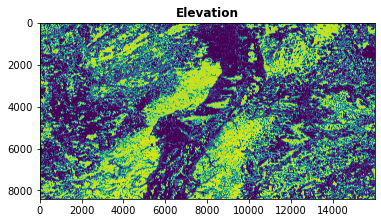

<AxesSubplot:title={'center':'Elevation'}>

In [27]:
rasterio.plot.show(band, title='Elevation')

In [28]:
rasterio.plot.plotting_extent(dataset)

(6.0, 10.0, 47.9, 50.0)

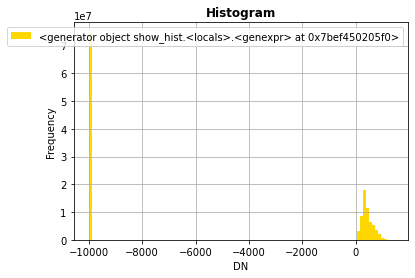

In [30]:
rasterio.plot.show_hist(band, bins=100)

Note that you need to explicity filter out nodata values at read time.

In [31]:
band = dataset.read(masked=True)
band

masked_array(
  data=[[[379.9346618652344, 379.9346618652344, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [259.5505065917969, 259.5505065917969, 260.3053283691406, ...,
          737.2267456054688, 736.4583740234375, 736.4583740234375],
         [--, --, --, ..., 737.5120849609375, 736.7557373046875,
          736.7557373046875],
         [--, --, --, ..., 738.052001953125, 737.4833374023438,
          737.4833374023438]]],
  mask=[[[False, False,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [False, False, False, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False]]],
  fill_value=-9999.0,
  dtype=float32)

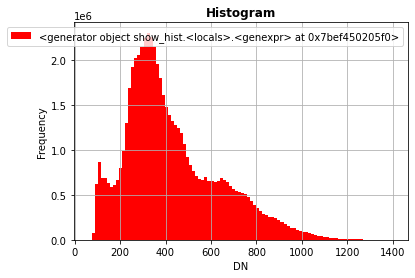

In [32]:
rasterio.plot.show_hist(band, bins=100)

Alternatively (e.g. when raster missing nodata definition, which in practice happens quite often :-)) you need to explicitly mask on your own the input data.

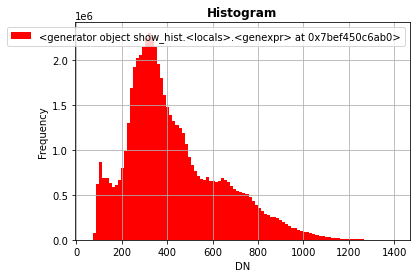

In [33]:
import numpy as np

band = dataset.read()
band_masked = np.ma.masked_array(band, mask=(band == -9999.0)) # mask whatever required
band_masked
rasterio.plot.show_hist(band_masked, bins=100)

The `rasterio` can package can also read directly multi-bands images. 

In [34]:
! gdalbuildvrt -separate /tmp/glad_ard_SVVI.vrt tree_height/geodata_raster/glad_ard_SVVI_m*.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [35]:
multi = rasterio.open('/tmp/glad_ard_SVVI.vrt', mode='r')

In [36]:
m = multi.read()
m.shape

(3, 8400, 16000)

Note that rasterio uses bands/rows/cols order in managing images, which is not the same of other packages!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


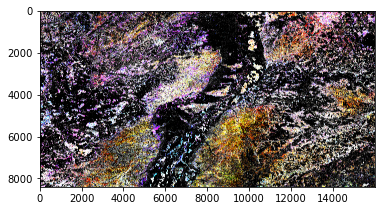

<AxesSubplot:>

In [37]:
rasterio.plot.show(m)

In [38]:
im = rasterio.plot.reshape_as_image(m) # rasterio.plot.reshape_as_raster(m) to reverse
im.shape

(8400, 16000, 3)

## 1.2 An example of computation: NDVI

In [39]:
! gdalbuildvrt -separate /tmp/lsat7_2002.vrt /usr/local/share/data/north_carolina/rast_geotiff/lsat7_2002_*.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [40]:
lsat = rasterio.open('/tmp/lsat7_2002.vrt', mode='r')

The real computation via `numpy` arrays

In [41]:
lsat_bands = lsat.read(masked=True)
ndvi = (lsat_bands[3]-lsat_bands[2]) / (lsat_bands[3]+lsat_bands[2])
ndvi.min(), ndvi.max()

(-0.9565217391304348, 0.9787234042553191)

In [42]:
lsat_bands.shape

(9, 475, 527)

In order to write the result all metainfo must be prepared, the easiest way is by using the input ones.

In [43]:
lsat.profile

{'driver': 'VRT', 'dtype': 'int32', 'nodata': -9999.0, 'width': 527, 'height': 475, 'count': 9, 'crs': CRS.from_epsg(32119), 'transform': Affine(28.5, 0.0, 629992.5,
       0.0, -28.5, 228513.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True}

In [44]:
profile = lsat.profile
profile.update(dtype=rasterio.float32, count=1, driver='GTiff')
profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 527, 'height': 475, 'count': 1, 'crs': CRS.from_epsg(32119), 'transform': Affine(28.5, 0.0, 629992.5,
       0.0, -28.5, 228513.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True}

In [45]:
with rasterio.open('/tmp/lsat7_2002_ndvi.tif', mode='w', **profile) as out:
    out.write(ndvi.astype(rasterio.float32), 1)

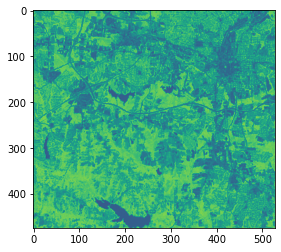

<AxesSubplot:>

In [46]:
rasterio.plot.show(ndvi)

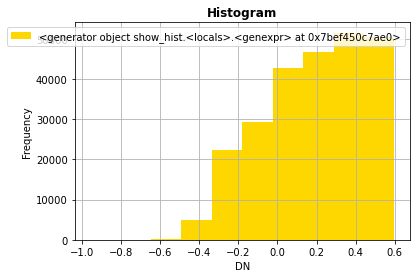

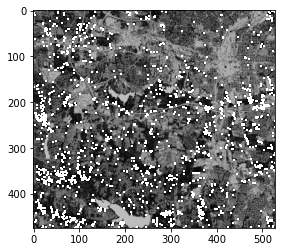

<AxesSubplot:>

In [47]:
import numpy as np

urb = np.ma.masked_array(ndvi, mask=(ndvi >= 0.6))
rasterio.plot.show_hist(urb)
rasterio.plot.show(urb,cmap='Greys')

In [48]:
ndvi_stats = [ndvi.min(), ndvi.mean(), np.ma.median(ndvi), ndvi.max(), ndvi.std()]
ndvi_stats

[-0.9565217391304348,
 0.19000604930927864,
 0.21518987341772153,
 0.9787234042553191,
 0.26075763486533654]

In [49]:
urb_stats = [urb.min(), urb.mean(), np.ma.median(urb), urb.max(), urb.std()]
urb_stats

[-0.9565217391304348,
 0.1865998791116573,
 0.21212121212121213,
 0.5980392156862745,
 0.2588748394018893]

It is possibile to use a vector model for masking in rasterio, let's see how.
First of all, we are creating a `GeoJSON` vector.

In [50]:
%%bash

cat >/tmp/clip.json <<EOF
{
"type": "FeatureCollection",
"name": "clip",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:EPSG::32119" } },
"features": [
{ "type": "Feature", "properties": { "id": null }, "geometry": { "type": "Polygon", "coordinates": [ [ [ 635564.136364065110683, 225206.211590493854601 ], [ 641960.631793407374062, 221261.067702935513807 ], [ 638781.535262656398118, 218005.366436503856676 ], [ 633610.715604206197895, 220878.044024531787727 ], [ 635564.136364065110683, 225206.211590493854601 ] ] ] } }
]
}
EOF


In [51]:
! ogrinfo -al /tmp/clip.json

INFO: Open of `/tmp/clip.json'
      using driver `GeoJSON' successful.

Layer name: clip
Geometry: Polygon
Feature Count: 1
Extent: (633610.715604, 218005.366437) - (641960.631793, 225206.211590)
Layer SRS WKT:
PROJCRS["NAD83 / North Carolina",
    BASEGEOGCRS["NAD83",
        DATUM["North American Datum 1983",
            ELLIPSOID["GRS 1980",6378137,298.257222101,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4269]],
    CONVERSION["SPCS83 North Carolina zone (meters)",
        METHOD["Lambert Conic Conformal (2SP)",
            ID["EPSG",9802]],
        PARAMETER["Latitude of false origin",33.75,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8821]],
        PARAMETER["Longitude of false origin",-79,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8822]],
        PARAMETER["Latitude of 1st standard parallel",36.1666666666667,
         

In [53]:
import rasterio.mask
import fiona

In [54]:
with fiona.open('/tmp/clip.json', 'r') as geojson:
    shapes = [feature['geometry'] for feature in geojson]
shapes

[{'type': 'Polygon',
  'coordinates': [[(635564.1363640651, 225206.21159049385),
    (641960.6317934074, 221261.0677029355),
    (638781.5352626564, 218005.36643650386),
    (633610.7156042062, 220878.0440245318),
    (635564.1363640651, 225206.21159049385)]]}]

In [55]:
clip_image, clip_transform = rasterio.mask.mask(lsat, shapes, crop=True) # why transform? ;-)
clip_image.shape

(9, 253, 294)

In [56]:
lsat.meta

{'driver': 'VRT',
 'dtype': 'int32',
 'nodata': -9999.0,
 'width': 527,
 'height': 475,
 'count': 9,
 'crs': CRS.from_epsg(32119),
 'transform': Affine(28.5, 0.0, 629992.5,
        0.0, -28.5, 228513.0)}

In [57]:
profile = lsat.meta
profile.update({'driver': 'GTiff', 
                'width': clip_image.shape[1], 
                'height': clip_image.shape[2], 
                'transform': clip_transform,
               })
profile

{'driver': 'GTiff',
 'dtype': 'int32',
 'nodata': -9999.0,
 'width': 253,
 'height': 294,
 'count': 9,
 'crs': CRS.from_epsg(32119),
 'transform': Affine(28.5, 0.0, 633583.5,
        0.0, -28.5, 225207.0)}

In [58]:
dst = rasterio.open('/tmp/clipped.tif', 'w+', **profile)
dst.write(clip_image)

In [59]:
dst.shape

(294, 253)

In [60]:
rst = dst.read(masked=True)
rst.shape

(9, 294, 253)

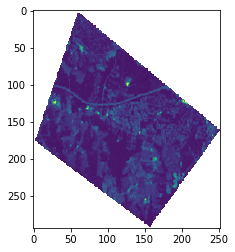

<AxesSubplot:>

In [61]:
rasterio.plot.show(rst[0])

Note that all read/write operation in RasterIO are performed for the whole size of the dataset, so the package is limited (somehow ...) by memory available. An alternative is using *windowing* in read/write operation.

In [62]:
import rasterio.windows

rasterio.windows.Window(0,10,100,100)

Window(col_off=0, row_off=10, width=100, height=100)

In [63]:
win = rasterio.windows.Window(0,10,100,100)
src = rasterio.open('/tmp/clipped.tif', mode='r')
w = src.read(window=win)
w.shape

(9, 100, 100)

Of course if you tile the input source and output sub-windows of results, a new trasform will need to be provided for each tile, and the `window_transform()` method can be used for that.

In [64]:
src.transform

Affine(28.5, 0.0, 633583.5,
       0.0, -28.5, 225207.0)

In [65]:
src.window_transform(win)

Affine(28.5, 0.0, 633583.5,
       0.0, -28.5, 224922.0)

Note that in many cases could be convenient aligning to the existing (format related) block size organization of the file, which *should* be the minimal chunck of I/O in GDAL.

In [66]:
for i, shape in enumerate(src.block_shapes, 1):
    print(i, shape)

1 (1, 253)
2 (1, 253)
3 (1, 253)
4 (1, 253)
5 (1, 253)
6 (1, 253)
7 (1, 253)
8 (1, 253)
9 (1, 253)


More information, examples and documentation about `RasterIO` are [here](https://rasterio.readthedocs.io/en/stable/index.html)

 ## 1.3 The rio CLI tool 

RasterIO has also a command line tool (`rio`) which can be used to perform a series of operation on rasters, which complementary in respect with the GDAL tools.If you install rasterio from distribution/kit it will reside in the ordinary system paths (note: you could find a `rasterio` binary instead of `rio`). If you install from the PyPI repository via `pip` it will install under `~/.local/bin`.

In [67]:
! rio --help

Usage: rio [OPTIONS] COMMAND [ARGS]...

  Rasterio command line interface.

Options:
  -v, --verbose           Increase verbosity.
  -q, --quiet             Decrease verbosity.
  --aws-profile TEXT      Select a profile from the AWS credentials file
  --aws-no-sign-requests  Make requests anonymously
  --aws-requester-pays    Requester pays data transfer costs
  --version               Show the version and exit.
  --gdal-version
  --show-versions         Show dependency versions
  --help                  Show this message and exit.

Commands:
  blocks     Write dataset blocks as GeoJSON features.
  bounds     Write bounding boxes to stdout as GeoJSON.
  calc       Raster data calculator.
  clip       Clip a raster to given bounds.
  convert    Copy and convert raster dataset.
  edit-info  Edit dataset metadata.
  env        Print information about the Rasterio environment.
  gcps       Print ground control points as GeoJSON.
  info       Print information about a data file.
  insp     

In [68]:
! rio bounds --indent 1 tree_height/geodata_raster/elev.tif # output a GeoJSON polygon for the bounding box

{
 "bbox": [
  6.0,
  47.9,
  10.0,
  50.0
 ],
 "geometry": {
  "coordinates": [
   [
    [
     6.0,
     47.9
    ],
    [
     10.0,
     47.9
    ],
    [
     10.0,
     50.0
    ],
    [
     6.0,
     50.0
    ],
    [
     6.0,
     47.9
    ]
   ]
  ],
  "type": "Polygon"
 },
 "properties": {
  "filename": "elev.tif",
  "id": "0",
  "title": "tree_height/geodata_raster/elev.tif"
 },
 "type": "Feature"
}


A quite interesting feature is the raster calculator which uses a Lisp-like language notation, which is the s-expression notation of *Snuggs*, part of `numpy`. Largely undocumented, you need to have a look to the code
[here](https://github.com/mapbox/snuggs/blob/master/snuggs/__init__.py) and its README file :-(

In [69]:
! rio calc "(+ 2.0 (* 0.95 (read 1)))" --overwrite tree_height/geodata_raster/elev.tif /tmp/elev.tif # Lisp like lists :-( 

Simple comuputations can be done via `rio` or written via ad hoc script at your will. 

# 2. Preparing the dataset for next ML exercises via rasterio

From here on, we will use rasterio to prepare data for manipulating the GEDI dataset that will be used later.

The dataset is documented here: 
https://lpdaac.usgs.gov/documents/986/GEDI02_UserGuide_V2.pdf

The notebooks which will use those data are the ``Tree_Height_*.ipynb``

## 2.1 Description

The **Global Ecosystem Dynamics Investigation (GEDI)** mission aims to characterize ecosystem structure and dynamics to enable radically improved quantification and understanding of the Earth’s carbon cycle and biodiversity. The GEDI instrument produces high resolution laser ranging observations of the 3-dimensional structure of the Earth. GEDI is attached to the **International Space Station (ISS)** and collects data globally between 51.6° N and 51.6° S latitudes at the highest resolution and densest sampling of any light detection and ranging (lidar) instrument in orbit to date. Each GEDI Version 2 granule encompasses one-fourth of an ISS orbit and includes georeferenced metadata to allow for spatial querying and subsetting.

The purpose of the **GEDI Level 2A Geolocated Elevation and Height Metrics product (GEDI02_A)** is to provide waveform interpretation and extracted products from each GEDI01_B received waveform, including ground elevation, canopy top height, and relative height (RH) metrics. The methodology for generating the GEDI02_A product datasets is adapted from the Land, Vegetation, and Ice Sensor (LVIS) algorithm. The GEDI02_A product is provided in HDF5 format and has a spatial resolution (average footprint) of 25 meters.

The GEDI02_A data product contains 156 layers for each of the eight beams, including ground elevation, canopy top height, relative return energy metrics (e.g., canopy vertical structure), and many other interpreted products from the return waveforms.

## 2.2 Downloading data

You should already performed what follows, here only for reference.

    cd ~/SE_data
    git pull
    rsync -hvrPt --ignore-existing ~/SE_data/* /media/sf_LVM_shared/my_SE_data
    cd  /media/sf_LVM_shared/my_SE_data/exercise

    pip3 install gdown # Google Drive access

    [ -f tree_height.tar.gz ] || ~/.local/bin/gdown 1Y60EuLsfmTICTX-U_FxcE1odNAf04bd-
    [ -d tree_height ] || tar xvf tree_height.tar.gz

In [ ]:
! ls tree_height/txt/eu_x_y_*

In [ ]:
! head tree_height/txt/eu_x_y_select.txt

In [ ]:
! wc -l tree_height/txt/eu_x_y_select.txt # quite a lots of coords!

In [ ]:
! head -3 tree_height/txt/eu_x_y_predictors_select.txt # what we would get

In [ ]:
! ls tree_height/geodata_raster/*.tif

The goal of the next few snippets of code is creating in Python and rasterio. That can be done either by using th `rio` tool or completely by Python script.

## 2.3 Running `rio` tool and using the `bash` shell and its tools

First of all, the input for rio-sample submodule needs to be in list form, and that can be easily done via `sed` tool (or even `awk` if you prefer so):

In [ ]:
! head tree_height/txt/eu_x_y_select.txt | sed -e 's/ /,/' -e 's/^/[/' -e 's/$/]/' # why and how?

Once created a compatible input data file for `rio`, it can be used to sample every georaster. 

In [ ]:
! head tree_height/txt/eu_x_y_select.txt | sed -e 's/ /,/' -e 's/^/[/' -e 's/$/]/' | rio sample tree_height/geodata_raster/BLDFIE_WeigAver.tif

Now, in principle you could stack together the input predictors and apply later the sampling. That could be done via `gdalbuildvrt` or `rio-stack`, BUT they both work currently only for homogeneous `dtype`, which is not our case, unfortunately.

*Homework: extract data types and sizes from all those files and check rasters are different types with the same dimensions. Hint: you can do that via rio or gdal tools or pktools* 

In [ ]:
# rio stack `ls tree_height/geodata_raster/*.tif|grep -Ev 'latitude|longitude'` -o /tmp/tree_height_preds.tif
# gdalbuildvrt tree_height/geodata_raster/*.tif -o /tmp/predictors.vrt

One quite simple way to get the final result is using `rio-sample` to sample separately each field, then using `paste` to join together each per-field file.

In [ ]:
%%bash

# this is VERY slow on 1M of records...

FILES=$(ls tree_height/geodata_raster/*.tif|grep -Ev 'latitude|longitude')
HEADER=''
for n in $FILES 
do 
    field=$(basename $n .tif)
    echo $field
    HEADER="$HEADER $field" # create header for later
    sed -e 's/ /,/' -e 's/^/[/' -e 's/$/]/' tree_height/txt/eu_x_y_select.txt|rio sample $n | tr -d '[]' >/tmp/$field.field
done

seq $(wc -l tree_height/txt/eu_x_y_select.txt|cut -d' ' -f1) >/tmp/ids
echo 'ID X Y ' "$FIELDS" >/tmp/fields
paste -d ' ' /tmp/ids tree_height/txt/eu_x_y_select.txt $FILES >>/tmp/fields # this is our result !

Of course, the same result can be achieved with direct read/write via rasterio packagein one full Python script. 

## 2.4 A single Python script construction, step by step

Due to the size of the dataset it is mandatory increasing the memory available for the VM and possibly add on demand swap space (i.e. virtual memory on disk), for instance via:

    sudo apt install swapspace
    
Of course, consider that eventually it could require a lot of temporary storage taken under `/var/lib/swapspace` which could be freed after use.

In [ ]:
import csv
import glob
import rasterio
import os.path

In [ ]:
files = []
for filename in glob.glob('tree_height/geodata_raster/[!l]*.tif'):
    ds = rasterio.open(filename, mode='r')
    files.append(ds)

In [ ]:
files

In [ ]:
print(len(files))

In [ ]:
os.path.basename(files[0].name)

In [ ]:
(name, ext) = os.path.splitext(os.path.basename(files[0].name))
name

In [ ]:
header = ''
for ds in files:
    field_name =   os.path.splitext(os.path.basename(ds.name))[0]
    header += ' '+field_name
header.lstrip()

Starting from those files now open in rasterio, it is possible to read the band and store them in a list

In [ ]:
band = files[0].read(1)
band

In [ ]:
bands = []
for ds in files:
    bands.append(ds.read(1))

In [ ]:
bands

Now let's have a trial for concatenating raster values

In [ ]:
with open('tree_height/txt/eu_x_y_select.txt') as csvfile:
    coords = csv.reader(csvfile, delimiter=' ')
    i = 1
    for (long, lat) in coords:
        print('{} {} {} '.format(i, long, lat),end='')
        for j, ds in enumerate(files):
            idx = ds.index(float(long), float(lat))
            band = bands[j]
            val = band[idx]
            print('{} '.format(val), end='')
        print("")b
        i+=1
        if i > 10: break # just for the very first rows and check


The first 10 rows seem correct in respect with the previous file, now it is only need to dump the rows to a file, with an appropriate header.

In [ ]:
%%timeit -r 1 -n 1
with open('tree_height/txt/eu_x_y_predictors_select_new.txt', 'w') as out:
    print('ID X Y' + header, file=out)
    with open('tree_height/txt/eu_x_y_select.txt') as csvfile:
        coords = csv.reader(csvfile, delimiter=' ')
        i = 1
        for (long, lat) in coords:
            print('{} {} {} '.format(i, long, lat),end='', file=out)
            for j, ds in enumerate(files):
                idx = ds.index(float(long), float(lat))
                band = bands[j]
                val = band[idx]
                print('{} '.format(val), end='', file=out)
            print("", file=out)
            i+=1
            if i>100000: break # that's to get a fast partial result...

You can notice that the output is extremely slow. Efficiency can be eventually increased by changing the buffering size from the default one.

In [ ]:
! head -3 tree_height/txt/eu_x_y_predictors_select_new.txt

## 2.5 The all-in-one final Python script

Running the script for the whole content of 1.2M of records take quite a full time, you can run it yourself or use the resulting file stored in the staging area of the VM and clone via git.

    #!/usr/bin/env python3
    #
    # This is the whole script written in a proper way to work even in bash.
    # You can copy&paste this block in a text `whatever.py` file, then
    # chmod a+x whatever.py 
    # and run it as ./whatever.py
    #
    
    import csv
    import glob
    import rasterio
    import os.path

    files = []
    for filename in glob.glob('tree_height/geodata_raster/[!l]*.tif'):
        ds = rasterio.open(filename, mode='r')
        files.append(ds)

    (name, ext) = os.path.splitext(os.path.basename(files[0].name))
    header = ''
    for ds in files:
        field_name = os.path.splitext(os.path.basename(ds.name))[0]
        header += ' '+field_name

    print('Reading raster files...')

    bands = []
    for ds in files:
        bands.append(ds.read(1))

    print('Writing samples')

    with open('tree_height/txt/eu_x_y_predictors_select_new.txt', 'w') as out:
        print('ID X Y' + header, file=out)
        with open('tree_height/txt/eu_x_y_select.txt') as csvfile:
            coords = csv.reader(csvfile, delimiter=' ')
            i = 1
            for (long, lat) in coords:
                print('{} {} {} '.format(i, long, lat),end='', file=out)
                for j, ds in enumerate(files):
                    idx = ds.index(float(long), float(lat))
                    band = bands[j]
                    val = band[idx]
                    print('{} '.format(val), end='', file=out)
                print("", file=out)
                if not i % 10: print('Record {} ...'.format(i))
                i+=1
        csvfile.close()
    out.close()

    print('Finished')

    exit(0)

This script is also available as `/media/sf_LVM_shared/my_SE_data/exercise/RasterIO_final_script.py` or `/media/sf_LVM_shared/my_SE_data/exercise/Tree_Height_02Predictors_extraction_python1.py`


Note that this _not_ an efficient implementation, but a simple one, largely based on what one could implement using other common CLI tools, including `rio`.

In order to get a faster approach it is required using a _vectorized_ implementation, i.e. using a set of functions that can work in fast/parallel mode to sample raster bands on the required pairs of coordinates.

See an alternative implementation in the `/media/sf_LVM_shared/my_SE_data/exercise/Tree_Height_02Predictors_extraction.ipynb` notebook and its linked `/media/sf_LVM_shared/my_SE_data/exercise/Tree_Height_02Predictors_extraction_python1.py` script.


# 3. Beyond the basics

Rasterio package is built on the basis of multiple sub-modules and one main sub-package (`rasterio.rio`).

Some sub-modules are not of general interest, for instance:

* `rasterio.rpc` is used for orthorectification of images via rational polinomial
* `rasterio.session` is used for working in cloud infrastructures (e.g. AWS, Azure, GCloud, etc.)
* `rasterio.control` is used to manage GCPs representations

Other modules are of general interest, instead

* `rasterio.io`
* `rasterio.env` to manage GDAL engine environment and drivers
* `rasterio.crs` to manage the image SRS
* `rasterio.transform` to manage the geo-transform associated with the data
* `raster.warp` to mimic GDAL warping (reprojections)
* `raster.window` to work onto sub-windows of data
* `raster.vrt` to work on GDAL VRT layers
* `raster.plot` provide simple graphics operations 


Documentation is avaiable [here](https://rasterio.readthedocs.io/en/stable/index.html).